# SciKit K-means Clustering

Exploring SciKit-Learn (https://scikit-learn.org/stable/) for semantic search.  Here I am looking at the k-means approach (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py).  Specifically the Mini-Batch K-Means clustering (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html).  

There are MANY approaches (https://scikit-learn.org/stable/auto_examples/index.html#cluster-examples) and it would be nice to get some guidance on what might make a good approach for building a similarity matrix of descriptive abstracts for datasets. 

## Notes:

Some search concepts are:

* Geolocation: "Gulf of Mexico", "Bay of Fundy", "Georges Bank"
* Parameter: "chlorophyll", "abundance", "dissolved organic carbon"
* Species: "calanus finmarchicus"
* Instrument": "CTD", "bongo net"
* Project: "C-DEBI"

The worry is these by themselves just become "frequncy searches".   What we want are search phrases that we can pull semantics from.  

```
!apt-get install libproj-dev proj-data proj-bin -qq
!apt-get install libgeos-dev -qq
```

## Imports and Inits

In [1]:
!pip install -q PyLD
!pip install -q boto3
!pip install -q minio
!pip install -q rdflib==4.2.2
!pip install -q cython
!pip install -q cartopy
!pip install -q SPARQLWrapper
!pip install -q geopandas
!pip install -q contextily==1.0rc2
!pip install -q rdflib-jsonld==0.5.0


In [3]:
import requests
import json
import rdflib
import pandas as pd
from pandas.io.json import json_normalize 
import concurrent.futures
import urllib.request
import dask, boto3
from SPARQLWrapper import SPARQLWrapper, JSON
import numpy as np
import geopandas
import matplotlib.pyplot as plt
import shapely

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
 

dbsparql = "http://dbpedia.org/sparql"
okn = "http://graph.openknowledge.network/blazegraph/namespace/samplesearth/sparql"
whoi = "https://lod.bco-dmo.org/sparql"    
    
# Pandas options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Data Loading

## Gleaner Data

First lets load up some of the data Gleaner has collected.  This is just simple data graph objects and not any graphs or other processed products from Gleaner. 

In [4]:
# Set up our S3FileSystem object
import s3fs 
oss = s3fs.S3FileSystem(
      anon=True,
      client_kwargs = {"endpoint_url":"https://oss.geodex.org"}
   )
# oss.ls('gleaner/summoned')

In [5]:
# # A simple example of grabbing one item...  
# import json 

# jld = ""
# with oss.open('gleaner/summoned/opentopo/231f7fa996be8bd5c28b64ed42907b65cca5ee30.jsonld', 'rb') as f:
#   #print(f.read())
#    jld = f.read().decode("utf-8", "ignore").replace('\n',' ')
#    json = json.loads(jld)

# document = json['description']
# print(document)

In [6]:
import json

@dask.delayed()
def read_a_file(fn):
    # or preferably open in text mode and json.load from the file
    with oss.open(fn, 'rb') as f:
        #return json.loads(f.read().replace('\n',' '))
        return json.loads(f.read().decode("utf-8", "ignore").replace('\n',' '))

# buckets = ['gleaner/summoned/dataucaredu', 'gleaner/summoned/getiedadataorg', 'gleaner/summoned/iris', 'gleaner/summoned/opentopo', 'gleaner/summoned/ssdb', 'gleaner/summoned/wikilinkedearth', 'gleaner/summoned/wwwbco-dmoorg', 'gleaner/summoned/wwwhydroshareorg', 'gleaner/summoned/wwwunavcoorg']

buckets = ['gleaner/summoned/opentopo']

filenames = []

for d in range(len(buckets)):
  print("indexing {}".format(buckets[d]))
  f = oss.ls(buckets[d])
  filenames += f

#filenames = oss.cat('gleaner/summoned/opentopo', recursive=True)
output = [read_a_file(f) for f in filenames]
print(len(filenames))


indexing gleaner/summoned/opentopo
654


In [7]:
%%time

gldf = pd.DataFrame(columns=['name', 'url', "keywords", "description", "object"])

#for key in filenames:

for doc in range(len(output)):
#for doc in range(10):
#for key in filenames:
  #if ".jsonld" in key:
  if "/.jsonld" not in filenames[doc] :
    try:
      jld = output[doc].compute()
    except:
      print(filenames[doc])
      print("Doc has bad encoding")

    # TODO  Really need to flatten and or frame this
    try:
      desc = jld["description"]
    except:
      desc = "NA"
      continue
    kws = "keywords" #jld["keywords"]
    name = jld["name"]
    url = "NA" #jld["url"]
    object = filenames[doc]

    gldf = gldf.append({'name':name, 'url':url, 'keywords':kws, 'description': desc, 'object': object}, ignore_index=True)


CPU times: user 10.8 s, sys: 323 ms, total: 11.1 s
Wall time: 54 s


In [8]:
gldf.info()
# gldf.to_parquet('index.parquet.gzip',  compression='gzip') # optional save state here ...  one master parquet for Geodex? 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         654 non-null    object
 1   url          654 non-null    object
 2   keywords     654 non-null    object
 3   description  654 non-null    object
 4   object       654 non-null    object
dtypes: object(5)
memory usage: 25.7+ KB


## Feature extraction

Let's just worry about the description section for now.


In [10]:
vec = TfidfVectorizer(stop_words="english")
vec.fit(gldf.description.values)
features = vec.transform(gldf.description.values)

### Kmeans clusters

Guess at the number a few times since we don't have a prior idea who many natural clusterings we might expect

In [11]:
random_state = 0 

cls = MiniBatchKMeans(n_clusters=20, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(n_clusters=20, random_state=0)

In [12]:
# predict cluster labels for new dataset
cls.predict(features)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

array([18,  9, 18, 18, 18,  5, 18, 12, 18, 12, 15, 16,  0,  0, 15, 18, 15,
        1,  0,  5, 18, 12, 18,  0, 14,  8, 18, 13, 18, 12,  8, 18, 12, 18,
       16, 12,  2, 18,  0,  0, 17, 18,  6,  0,  0,  5,  2, 12,  2, 18, 12,
       15,  2, 17,  9, 11,  0, 12,  9,  1,  2,  0, 18,  2,  5, 12, 13, 15,
       17,  2,  2, 18, 18, 16,  0,  2, 18,  0, 13,  5, 18,  2,  0, 11, 18,
        0, 12, 14,  0,  0,  9,  8,  9, 11,  5,  9, 12, 17,  1, 12,  7,  0,
        9,  5,  2, 12, 13, 18, 18, 12,  2,  0,  0, 18, 18,  0,  0, 18, 18,
        8,  2,  2,  0, 18, 13,  1,  2,  9, 13,  0,  8, 18, 13, 12,  1,  2,
        2,  0, 16,  5,  0,  9,  0, 12,  0, 13, 12, 18, 18,  1,  2,  8, 13,
        1,  9,  0,  0,  2, 13, 15,  4,  0,  2, 12,  2, 18,  9,  1, 13,  5,
        0,  0, 18, 18,  0,  9, 15, 14, 18, 19,  3, 18, 15, 18,  2, 18,  0,
        8, 16, 18, 18,  0,  9, 13, 18, 17,  2,  2,  2, 18, 18, 17,  5, 11,
       18, 18, 18, 18, 13,  2, 18, 18, 18, 18, 18, 18, 19,  0, 18,  5,  2,
        5,  2,  0,  0,  2

In [13]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

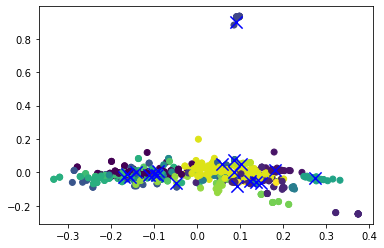

In [14]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

## Nearest Neighbor testing

In [15]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=10, metric='cosine')
knn.fit(features)

NearestNeighbors(metric='cosine', n_neighbors=10)

In [16]:
knn.kneighbors(features[0:1], return_distance=False)


array([[  0, 520, 395, 248, 355, 276, 176, 327, 598, 638]])

In [17]:
knn.kneighbors(features[0:1], return_distance=True)


(array([[0.        , 0.05126516, 0.37921939, 0.4165376 , 0.6984332 ,
         0.87318168, 0.87318168, 0.87318168, 0.87318168, 0.88349159]]),
 array([[  0, 520, 395, 248, 355, 276, 176, 327, 598, 638]]))

## Search testing

run a few test searches and then plot the first n (4) results

In [20]:
input_texts = ["New Zeland lidar data", "California housing", "new madrid seismic zone"]
input_features = vec.transform(input_texts)

D, N = knn.kneighbors(input_features, n_neighbors=4, return_distance=True)

for input_text, distances, neighbors in zip(input_texts, D, N):
    print("Input text = ", input_text[:200], "\n")
    for dist, neighbor_idx in zip(distances, neighbors):
        print("Distance = ", dist, "Neighbor idx = ", neighbor_idx)
        print(gldf.name[neighbor_idx])
        print(gldf.description[neighbor_idx][:400])
        print("-"*200)
    print("="*200)
    print()

Input text =  New Zeland lidar data 

Distance =  0.6759095922425897 Neighbor idx =  59
Bay of Plenty, New Zealand 2018-2019
Lidar was captured for BOPLASS Limited by AAM New Zealand between December 2018 and April 2019. The dataset was generated by AAM New Zealand and their subcontractors. The survey area includes Tauranga, Rotorua and Whakatane and the surrounding area. Data management and distribution is by Land Information New Zealand.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Distance =  0.6833093201645597 Neighbor idx =  470
Auckland South, New Zealand 2016-2017
Lidar was captured for Auckland Council by AAM New Zealand between September 2016 through to June 2017. The original dataset was generated by AAM New Zealand and their subcontractors. The survey area covers the southern Auckland suburbs and regions. Data management 